# Encoder-decoder for sequence-to-sequence tasks

In this tutorial, we will walk through a minimal example of encoder-decoder with attention mechanism.

This tutorial focuses on implementation. For basic concepts, refer to slides for lectures and recitations.




## Toy task: English spelling to pronunciation

We consider the same toy task as the last recitation, which is predicting the pronunciation (as sequence of phonemes) of an English word given its spelling.

The model architecture and hyperparameters are for demonstration purpose only. Do not copy them to your actual homework.

In [0]:
# Words with only E, I, N, S, T.
# Pronunciation is from http://www.speech.cs.cmu.edu/cgi-bin/pronounce
data = [
    ('SEE', 'S IY'),
    ('SET', 'S EH T'),
    ('SIT', 'S IH T'),
    ('SITE', 'S AY T'),
    ('SIN', 'S IH N'),
    ('TEEN', 'T IY N'),
    ('TIN', 'T IH N'),
    ('TIE', 'T AY'),
    ('TEST', 'T EH S T'),
    ('NET', 'N EH T'),
    ('NEET', 'N IY T'),
    ('NINE', 'N AY N')
]
letters = 'EINST'
# '<s>' for the beginning of sequence, '</s>' for the end of sequence, followed by actual phonemes
phonemes = ['<s>', '</s>', 'S', 'T', 'N', 'IY', 'IH', 'EH', 'AY']

Every target sequence is prepended with `<s>` and appended with `</s>`. This is necessary for the decoder to predict the first token and the end of the sequence.

In [3]:
import torch
from torch import nn
from torch.nn.utils.rnn import *

X = [torch.LongTensor([letters.find(c) for c in word]) for word, _ in data]
Y = [torch.LongTensor([phonemes.index(p) for p in ('<s> ' + pron + ' </s>').split()])for _, pron in data]
X_lens = torch.LongTensor([len(seq) for seq in X])
Y_lens = torch.LongTensor([len(seq) for seq in Y])
X = pad_sequence(X)
Y = pad_sequence(Y)
print(X)
print(Y)

NameError: name 'data' is not defined

## Encoder

The encoder is just a one-layer bi-directional LSTM. The encoder returns not only the encoded sequence, but also the final hidden state of the LSTM, which will be the initial hidden state of the decoder.

Size notation: `N` is the batch size, `T` is the maximum source sequence length, and `H` is the hidden size.

In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Encoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size // 2, bidirectional=True)
    
    def forward(self, X, lengths):
        """
        :param X: (N, T), source sequences
        :param lengths: (N,), lengths of source sequences
        :returns: (N, T, H) encoded source sequneces, and LSTM final states
        """
        X = self.embed(X)
        packed_X = pack_padded_sequence(X, lengths, enforce_sorted=False)
        packed_out, state = self.lstm(packed_X)
        out, _ = pad_packed_sequence(packed_out)
        return out, state

## Attention

This the simplest "dot product" attention, meaning that every attention logit is the dot product of a target (`query`) vector and a source (`context`) vector. Such an attention model has no parameter, but you may use more advanced attention mechanism with learnable parameters in real world.

Since there are a lot of uncommon operators, every line of code is annotated with input and output tensor sizes. 

The attention vectors are not used by other computations, but are returned for visualization. You will often want to visualize the attention matrix when debugging sequence-to-sequence models.

In [0]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
    
    def forward(self, query, context, lengths):
        """
        :param query: (N, H), decoder state of a single timestep
        :param context: (N, T, H), encoded source sequences
        :param lengths: (N,), lengths of source sequences
        :returns: (N, H) attended source context, and (N, T) attention vectors
        """
        # Compute (N, T) attention logits. "bmm" stands for "batch matrix multiplication".
        # Input/output shape of bmm: (N, T, H), (N, H, 1) -> (N, T, 1)
        attention = torch.bmm(context, query.unsqueeze(2)).squeeze(2)
        # Create an (N, T) boolean mask for all padding positions
        # Make use of broadcasting: (1, T), (N, 1) -> (N, T)
        mask = torch.arange(context.size(1)).unsqueeze(0) >= lengths.unsqueeze(1)
        # Set attention logits at padding positions to negative infinity.
        attention.masked_fill_(mask, -1e9)
        # Take softmax over the "source length" dimension.
        attention = nn.functional.softmax(attention, dim=1)
        # Compute attention-weighted sum of context vectors
        # Input/output shape of bmm: (N, 1, T), (N, T, H) -> (N, 1, H)
        out = torch.bmm(attention.unsqueeze(1), context).squeeze(1)
        return out, attention

In [8]:
lengths = torch.tensor([4,5,6])

mask = torch.arange(10).unsqueeze(0) >= lengths.unsqueeze(1)

In [13]:
a = torch.arange(30).view(3,10)

In [14]:
a.masked_fill_(mask, -1e9)

tensor([[          0,           1,           2,           3, -1000000000,
         -1000000000, -1000000000, -1000000000, -1000000000, -1000000000],
        [         10,          11,          12,          13,          14,
         -1000000000, -1000000000, -1000000000, -1000000000, -1000000000],
        [         20,          21,          22,          23,          24,
                  25, -1000000000, -1000000000, -1000000000, -1000000000]])

## Decoder

Each `forward` call of decoder deals with only one timestep.

Here, we use the LSTM output as the query of attention and concatenate the attended context with the LSTM output. There are many other (better) ways to use attention context in the decoder.

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTMCell(hidden_size, hidden_size)
        self.attention = Attention()
        self.output = nn.Linear(hidden_size * 2, vocab_size, bias=False)

    def forward(self, x, context, context_lengths, state=None):
        """
        :param x: (N,), target tokens in the current timestep
        :param context: (N, T, H), encoded source sequences
        :param context_lengths: (N,) lengths of source sequences
        :param state: LSTM hidden states from the last timestep (or from the encoder for the first step)
        :returns: prediction of target tokens in the next timestep, LSTM hidden states of the current timestep, and attention vectors
        """
        x = self.embed(x)
        new_state = self.lstm(x, state)
        x = new_state[0]
        x_att, attention = self.attention(x, context, context_lengths)
        x = torch.cat([x, x_att], dim=1)
        return self.output(x), new_state, attention

## Training

In training, we feed ground truth tokens into the decoder one step at a time, and let it predict the next token.

The loss function is just cross entropy loss, but only "real" tokens are counted, and padding tokens must be ignored. The loss of each batch is averaged over all "real" tokens.

In [9]:
torch.manual_seed(11785)
encoder = Encoder(len(letters), 4)
decoder = Decoder(len(phonemes), 4)
# Sum over the batch at every timestep. We manually divide the total loss by number of tokens.
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.1)

loss_history = []

for epoch in range(100):
    context, state = encoder(X, X_lens)
    # Context: (T, N, H) -> (N, T, H)
    context = context.transpose(0, 1)
    # Hidden states: (2, N, H) -> (N, 2*H)
    state = tuple(st.transpose(0, 1).reshape(X.size(1), -1) for st in state)

    loss = 0
    # Number of "real" tokens
    n_tokens = Y_lens.sum() - Y_lens.size(0)
    # List of attention vectors
    all_attentions = []
    for i in range(Y.size(0) - 1):
        out, state, attention = decoder(Y[i], context, X_lens, state)
        all_attentions.append(attention.detach())
        # Mask of sequenuces that haven't ended (i.e. current tokens are "real")
        active = i + 1 < Y_lens
        # Compute loss only on "real" outputs
        loss += criterion(out[active], Y[i + 1, active])
    # Divide by number of "real" tokens to get average loss
    loss /= n_tokens
    loss_history.append(loss.item())
    # Assemble attention vectors at each timestep into attention matrix.
    # The shape is (N, T_out, T_in)
    all_attentions = torch.stack(all_attentions, dim=1)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print('Final train loss:', loss_history[-1])

Final train loss: 0.038733527064323425


## Visualize loss and attention

The attention for this toy example doesn't work very well, but you should observe a clear diagonal on the attention matrix in the real life.

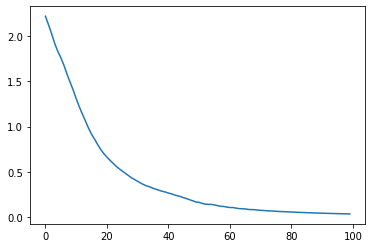

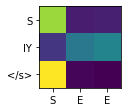

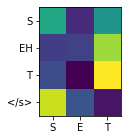

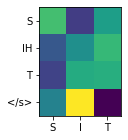

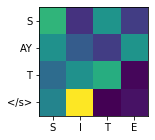

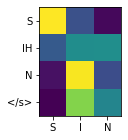

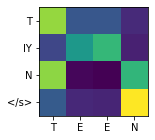

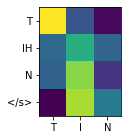

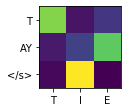

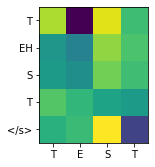

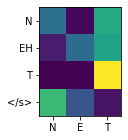

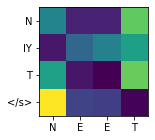

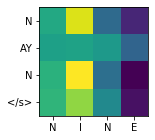

In [18]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.show()

for i in range(X.size(1)):
    fig, ax = plt.subplots(figsize=(X_lens[i] * 0.5, (Y_lens[i] -  1) * 0.5))
    ax.imshow(all_attentions[i, :Y_lens[i] - 1, :X_lens[i]].numpy())
    ax.set_xticks(np.arange(X_lens[i]))
    ax.set_yticks(np.arange(Y_lens[i] - 1))
    ax.set_xticklabels(list(data[i][0]))
    ax.set_yticklabels(data[i][1].split() + ['</s>'])
    ax.set_ylim(Y_lens[i]-1.5, -0.5)
    plt.show()

## Decoding

Here we demonstrate "greedy decoding", that is, choosing the token with the highest probability at every step. Beam search is the standard decoding algorithm nowadays, but is much harder to implement. Greedy decoding is equivalent to beam search with beam width of 1.

In [0]:
test_data = ['TEE', 'TINT', 'SINE', 'SENT']

test_X = [torch.LongTensor([letters.find(c) for c in word]) for word in test_data]
test_X_lens = torch.LongTensor([len(seq) for seq in test_X])
test_X = pad_sequence(test_X)

Here we decode one sample at a time. When using GPUs, it is favorable to decode a batch of samples at a time, to reduce GPU communication overhead.

In [17]:
for i in range(test_X.size(1)):
    context, state = encoder(test_X[:, i:i+1], test_X_lens[i:i+1])
    context = context.transpose(0, 1)
    state = tuple(st.transpose(0, 1).reshape(1, -1) for st in state)

    input_token = torch.LongTensor([phonemes.index('<s>')])
    seq = ['<s>']
    # Must terminate the generation in a finite amount of steps.
    while seq[-1] != '</s>' and len(seq) <= 10:
        out, state, _ = decoder(input_token, context, test_X_lens[i:i+1], state)
        # Get the most probable token, append it to the output sequence, and make it the next input token.
        out_token = torch.argmax(out.squeeze())
        seq.append(phonemes[out_token])
        input_token = torch.LongTensor([out_token])
    print(test_data[i], '->', ' '.join(seq[1:-1]))

TEE -> S IY
TINT -> T IH N
SINE -> S AY N
SENT -> S EH T
